In [1]:
import random as rnd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU

rnd.seed(5)

In [2]:
sensor = int(rnd.random() * 963)
print(sensor)

599


In [3]:
data = []
file = open("Dataset/train.txt", 'r')
lines = file.readlines()
for i in range(len(lines)):
  data.append([float(k) for k in lines[i].replace('\n', '')[1:-1].split(';')[sensor].split()])
file = open("Dataset/test.txt", 'r')
lines = file.readlines()
for i in range(len(lines)):
  data.append([float(k) for k in lines[i].replace('\n', '')[1:-1].split(';')[sensor].split()])
print(len(data))

440


In [4]:
labels = []
file = open("Dataset/train_labels.txt", 'r')
lines = file.readlines()
labels += [int(k) for k in lines[0][1:-1].split()]

file = open("Dataset/test_labels.txt", 'r')
lines = file.readlines()
labels += [int(k) for k in lines[0][1:-1].split()]
print(len(labels))

440


In [5]:
file = open("Dataset/randperm.txt", 'r')
lines = file.readlines()
seq = [int(k) for k in lines[0][1:-1].split()]
print(len(seq))

440


In [6]:
indices = np.argsort(seq)
seq = np.array(seq)[indices].tolist()
data = np.array(data)[indices].tolist()
labels = np.array(labels)[indices].tolist()

In [7]:
days = [[], [], [], [], [], [], []]
for i in range(len(labels)):
  days[labels[i] - 1].append(data[i])

1 : 62


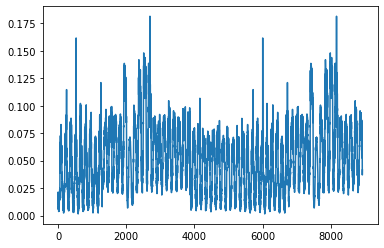

2 : 57


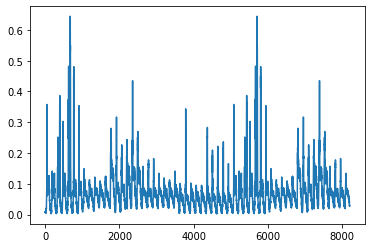

3 : 64


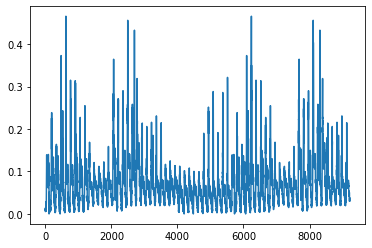

4 : 65


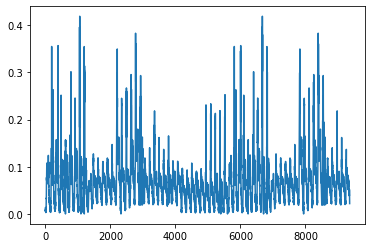

5 : 65


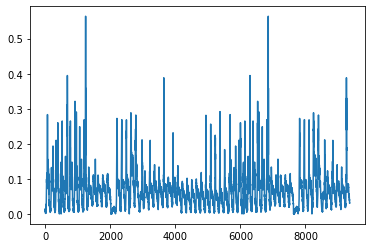

6 : 63


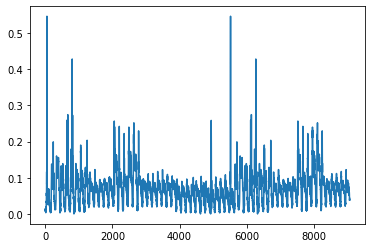

7 : 64


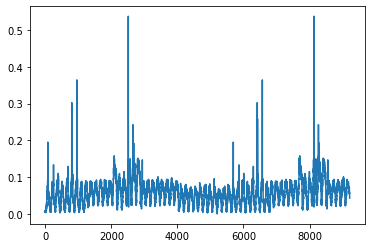

In [8]:
for i in range(7):
  print(i+1, ':', len(days[i]))
  plt.plot(sum(days[i], []))
  plt.show()

In [9]:
def toSupervised(data, jump):
  result = []
  for i in range(jump, len(data) - 1, jump):
    result.append([data[i-jump], data[i]])
  return np.array(result)

In [10]:
def scale(data):
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaler = scaler.fit(data)
	data = data.reshape(data.shape[0], data.shape[1])
	data_scaled = scaler.transform(data)
	return data_scaled

In [11]:
def invertScale( X, yhat):
	new_row = [x for x in X] + [yhat]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	return array[0, -1]

In [12]:
def fit_lstm(train, batch, epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(GRU(neurons, batch_input_shape=(batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for _ in range(epoch):
		model.fit(X, y, epochs=1, batch_size=batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [13]:
def run(train, test, epochs, batch, neurons, repeats):
  error_scores = []
  for r in range(repeats):
    train_trimmed = train[2:, :]
    lstm_model = fit_lstm(train_trimmed, batch, epochs, neurons)
    train_reshaped = train_trimmed[:, 0].reshape(len(train_trimmed), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=batch)
    test_reshaped = test[:,0:-1]
    test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
    output = lstm_model.predict(test_reshaped, batch_size=batch)
    predictions = []
    for i in range(len(output)):
      yhat = output[i,0]
      X = test[i, 0:-1]
      yhat = invertScale( X, yhat)
      predictions.append(yhat)
    rmse = math.sqrt(mean_squared_error(test[:, 0:-1], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)
  return error_scores

In [14]:
raw_data = np.array(sum(rnd.choice(days), []))
supervised_data = toSupervised(raw_data, 6)
scaled_data = scale(supervised_data)
print(scaled_data.min(), scaled_data.max())
train = scaled_data[:-int(0.3 * len(scaled_data))]
test = scaled_data[-int(0.3 * len(scaled_data)):]
print(len(train), len(test))

0.0 1.0
1058 453


In [15]:
neurons = [1,2,3,4,5]
batch_size = [1,3]
epochs = [100,200,500,1000]
repeats = 5

In [16]:
results = {}
for i in epochs:
  print(i)
  results[str(i)] = run(train, test, i, 1, 1, repeats)

100
453/453 [==============================] - 1s 1ms/step
1) Test RMSE: 0.024
453/453 [==============================] - 1s 1ms/step
2) Test RMSE: 0.025
453/453 [==============================] - 1s 1ms/step
3) Test RMSE: 0.023
453/453 [==============================] - 0s 985us/step
4) Test RMSE: 0.024
453/453 [==============================] - 1s 1ms/step
5) Test RMSE: 0.024
200
453/453 [==============================] - 1s 1ms/step
1) Test RMSE: 0.027
453/453 [==============================] - 1s 1ms/step
2) Test RMSE: 0.025
453/453 [==============================] - 0s 973us/step
3) Test RMSE: 0.027
453/453 [==============================] - 0s 992us/step
4) Test RMSE: 0.026
453/453 [==============================] - 1s 1ms/step
5) Test RMSE: 0.026
500
453/453 [==============================] - 1s 1ms/step
1) Test RMSE: 0.027
453/453 [==============================] - 1s 1ms/step
2) Test RMSE: 0.027
453/453 [==============================] - 0s 785us/step
3) Test RMSE: 0.026
453/4

In [17]:
for i in results.keys():
    print(i, ':', sum(results[i])/len(results[i]))

100 : 0.02404181389510919
200 : 0.02600610996146919
500 : 0.027162655146359176
1000 : 0.027516274904743142


In [18]:
results0 = {}
for i in batch_size:
  print(i)
  results0[str(i)] = run(train, test, 100, i, 1, repeats)

1
453/453 [==============================] - 0s 626us/step
1) Test RMSE: 0.025
453/453 [==============================] - 0s 555us/step
2) Test RMSE: 0.027
453/453 [==============================] - 0s 693us/step
3) Test RMSE: 0.027
453/453 [==============================] - 0s 750us/step
4) Test RMSE: 0.020
453/453 [==============================] - 0s 535us/step
5) Test RMSE: 0.026
3
151/151 [==============================] - 0s 626us/step
1) Test RMSE: 0.023
151/151 [==============================] - 0s 757us/step
2) Test RMSE: 0.028
151/151 [==============================] - 0s 2ms/step
3) Test RMSE: 0.026
151/151 [==============================] - 0s 1ms/step
4) Test RMSE: 0.022
151/151 [==============================] - 0s 1ms/step
5) Test RMSE: 0.024


In [19]:
for i in results0.keys():
    print(i, ':', sum(results0[i])/len(results0[i]))

1 : 0.02499572053389886
3 : 0.024519056786935813


In [20]:
results1 = {}
for i in neurons:
  print(i)
  results1[str(i)] = run(train, test, 100, 1, i, repeats)

1
453/453 [==============================] - 0s 716us/step
1) Test RMSE: 0.026
453/453 [==============================] - 1s 1ms/step
2) Test RMSE: 0.022
453/453 [==============================] - 1s 1ms/step
3) Test RMSE: 0.025
453/453 [==============================] - 1s 2ms/step
4) Test RMSE: 0.025
453/453 [==============================] - 1s 2ms/step
5) Test RMSE: 0.024
2
453/453 [==============================] - 1s 1ms/step
1) Test RMSE: 0.034
453/453 [==============================] - 1s 2ms/step
2) Test RMSE: 0.033
453/453 [==============================] - 0s 1ms/step
3) Test RMSE: 0.035
453/453 [==============================] - 0s 1ms/step
4) Test RMSE: 0.034
453/453 [==============================] - 0s 1ms/step
5) Test RMSE: 0.034
3
453/453 [==============================] - 0s 799us/step
1) Test RMSE: 0.033
453/453 [==============================] - 0s 942us/step
2) Test RMSE: 0.028
453/453 [==============================] - 0s 924us/step
3) Test RMSE: 0.033
453/453 [==

In [21]:
for i in results1.keys():
    print(i, ':', sum(results1[i])/len(results1[i]))

1 : 0.02419303815765656
2 : 0.0338613473241151
3 : 0.03218563154661354
4 : 0.03352192786182765
5 : 0.03599610071633791


453/453 [==============================] - 1s 1ms/step
Test RMSE: 0.0253619579


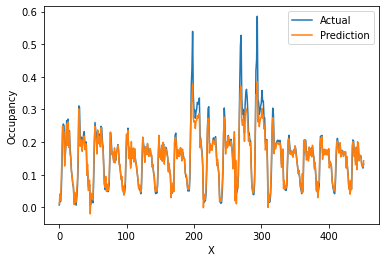

In [22]:
train_trimmed = train[2:, :]
lstm_model = fit_lstm(train_trimmed, 1, 500, 1)
train_reshaped = train_trimmed[:, 0].reshape(len(train_trimmed), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
test_reshaped = test[:,0:-1]
test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
output = lstm_model.predict(test_reshaped, batch_size=1)
predictions = []
for i in range(len(output)):
  yhat = output[i,0]
  X = test[i, 0:-1]
  yhat = invertScale( X, yhat)
  predictions.append(yhat)
rmse = math.sqrt(mean_squared_error(test[:, 0:-1], predictions))
print('Test RMSE: %.10f' % rmse)
plt.plot(test[:, 0:-1])
plt.plot(predictions)
plt.legend(['Actual', 'Prediction'])
plt.xlabel('X')
plt.ylabel('Occupancy')
plt.show()